In [1]:
!pip install torchinfo


다음은 GoogLeNet 논문(“Going Deeper with Convolutions”, 2014)과 PyTorch 구현(예: torchvision의 구현) 간의 주요 차이점입니다(일부 항목은 구현에 따라 달라질 수 있음):

- Batch Normalization 사용

    - 구현: 각 convolution 계층 후에 Batch Normalization을 적용하여 수치 안정성과 학습 속도를 개선합니다.
    - 논문 : LRN 사용

- Auxiliary Classifier 처리 방식

    - 구현: 보통 aux_logits 플래그로 선택적으로 사용하며, 훈련 시에만 활성화하거나 완전히 생략할 수 있습니다.
    - 논문: 두 개의 auxiliary classifier가 항상 포함되어 중간 계층에서 학습 보조 역할을 수행하지만, 이후 연구에서 그 효과가 크지 않다는 결과가 많아 선택적으로 적용하도록 하였습니다.

- 데이터셋 변경
    - 구현: ImageNet 대신 CIFAR-10 데이터셋을 사용하며, 입력 이미지를 224×224로 resize하는 등 전처리 방식에 차이가 있습니다.
    - 논문: ImageNet 데이터셋(일반적으로 224×224 크기 이미지)을 기준으로 설계되었습니다.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

import time
import copy

In [6]:
#basicConv2d : 합성곱 + batchNorm + ReLU
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).___init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

# Inception 모듈
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], dim=1)


class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AuxiliaryClassifier, self).__init__()
        self.avgpool=nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(128*4*4, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


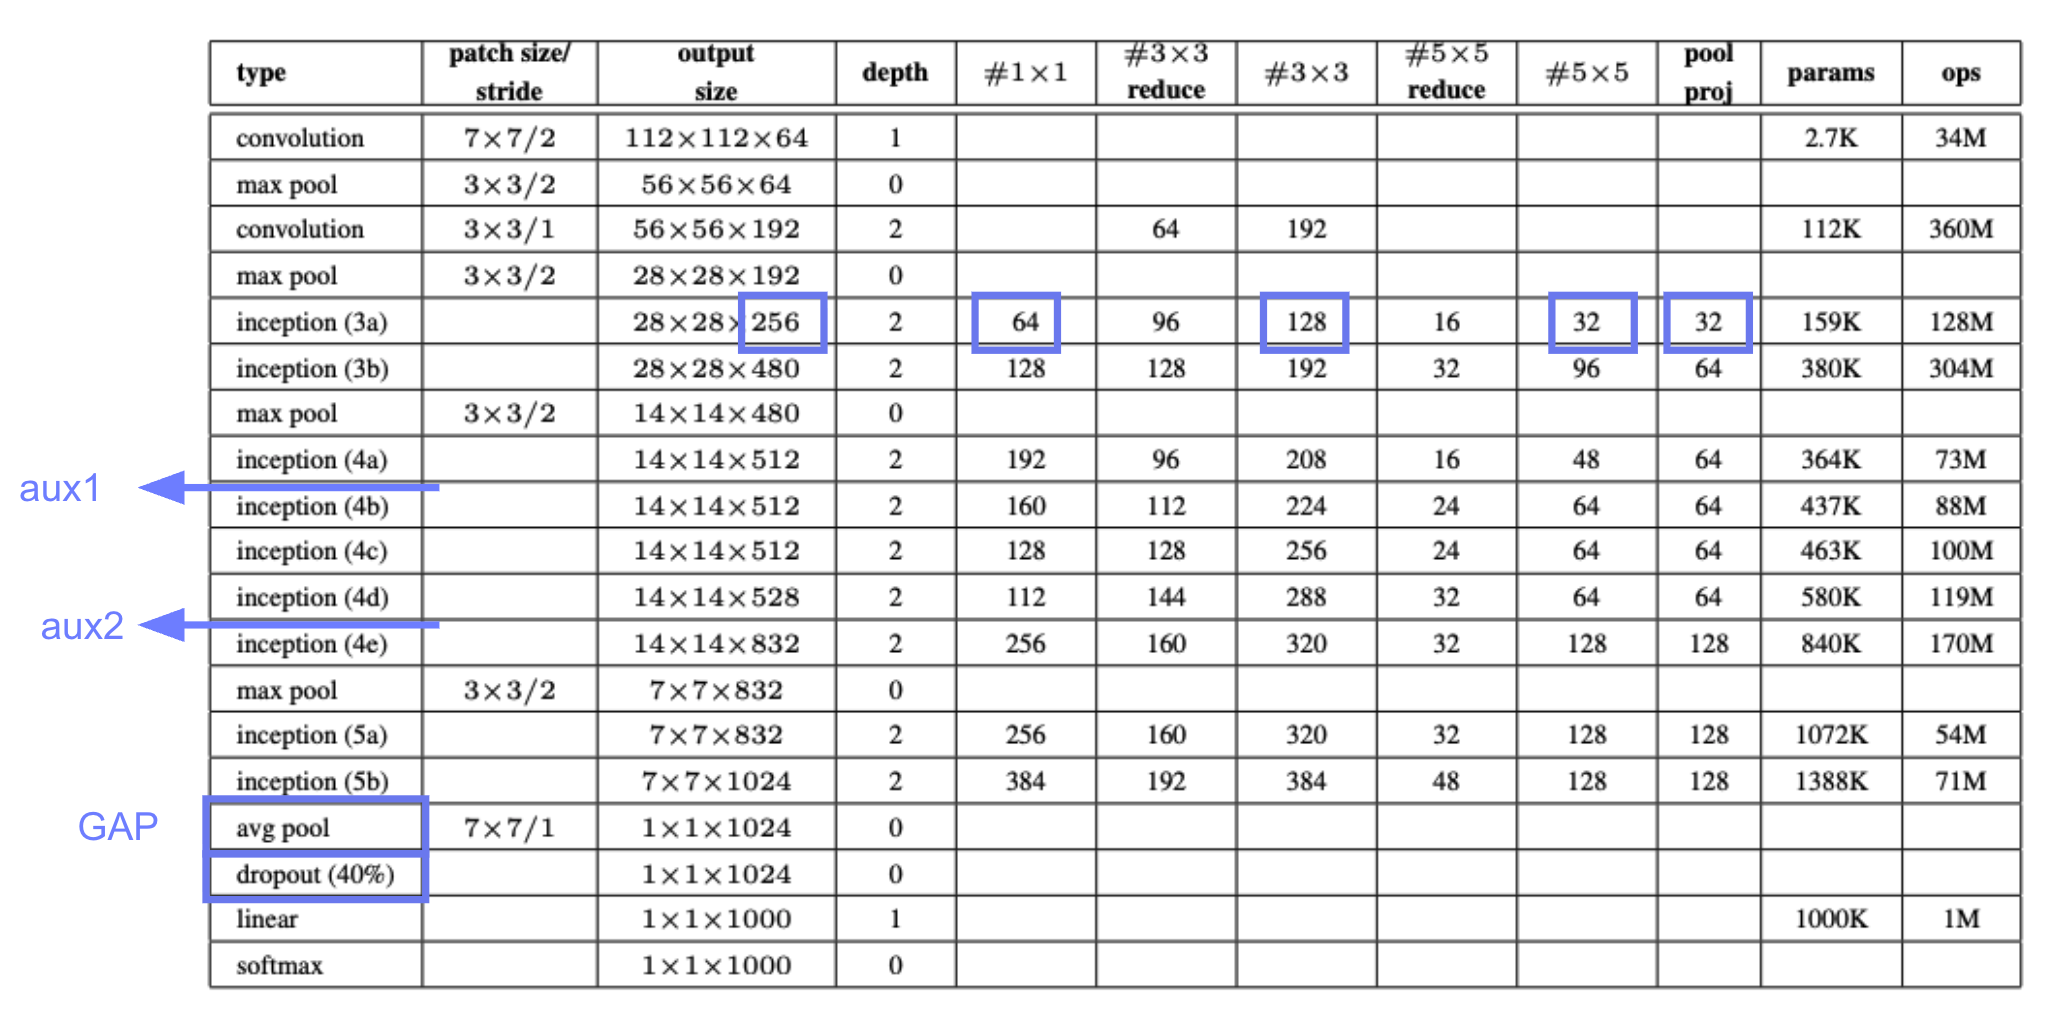

In [8]:
#GoogLeNet
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10, aux_logits=False, transform_input=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits
        self.transform_input = transform_input

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)      # 출력: 256 채널
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)     # 출력: 480 채널
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)      # 출력: 512 채널
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)     # 출력: 512 채널
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)     # 출력: 512 채널
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)     # 출력: 528 채널
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)    # 출력: 832 채널
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)    # 출력: 832 채널
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)    # 출력: 1024 채널

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

        if self.aux_logits:
            self.aux1 = AuxiliaryClassifier(512, num_classes)
            self.aux2 = AuxiliaryClassifier(528, num_classes)

    def forward(self, x):
        if self.transform_input:
            # (필요 시 입력 변환 코드 추가)
            pass

        # 224x224 크기의 입력을 예상
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)
        else:
            aux1 = None

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.aux_logits and self.training:
            aux2 = self.aux2(x)
        else:
            aux2 = None

        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        main_out = self.fc(x)

        if self.aux_logits and self.training:
            return main_out, aux2, aux1
        else:
            return main_out

In [15]:
model = torchvision.models.googlenet(weights='GoogLeNet_Weights.IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 67.6MB/s]
